In [1]:
%matplotlib inline
import matplotlib as mpl
#mpl.use('Agg')
import numpy as np
import pylab as py
#import Extract_ncfile_save_fluxes_radiation
#import Reload_save_interpolated as svintp
import matplotlib.cm as cm
from reverse_cmap import rcmap
import sys
import os
import errno
import netCDF4 as nc
from mpl_toolkits import mplot3d
# from mayavi import mlab

BuRd = rcmap(cm.RdBu)

import hickle as hkl

#source_dirc=svintp.source
#exp_dirc=["aqua_2m/","aqua_20m/","land_rec20m/"]

## A function to save a dictionary ##
def save(filename,dictionary):
    hkl.dump(dictionary, filename, mode='w')

## A function to load a dictionary ## 
def load(filename):
    dictionary = hkl.load(filename)
    return dictionary

def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

# dirc=sys.argv

####################
#### smoothening ###
####################

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

#source='/project2/tas1/pragallva/Fall_quarter_2017/post_process_data/land_realtest/'
source_dir='/project2/tas1/pragallva/Spring_quarter/post_process_data/'
source = source_dir+'aqua_2m/'
            
py.rc('text', usetex=True)
py.rc('font', family='serif', serif='Palatino',weight='bold')

a=6371.0e3
R=a

In [2]:
I1=r'$ ({\Delta D \Delta I_{m}})_{o}$'
I2=r'$-(\Delta D) (\Delta I_{m})$'
I3=r'$-(\Delta D) {I_{m_{o}}}$'
I4=r'$-{D_{o}} (\Delta I_{m})$'
ISUM=r'$\Delta I =$ '+I1 +I2 +I3 +I4
Iorig=r'$\Delta I =$' + r'$\Delta\langle[\overline{v^{\prime}m^{\prime}}]\rangle$'

In [3]:
import glob
import numpy as np
import scipy.io as sio
import pylab as py
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy import stats

#### Invoke all the files

m5=(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/am2/HC0_la5m_oc5m/*.hkl'))
# m10=(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la10m_oc10m/*.hkl'))
m50=(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/am2/HC0_la50m_oc50m/*.hkl'))
#m100=(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la100m_oc100m/*.hkl'))

In [4]:
# m50

In [5]:
# t=0;f=1;r=3;c=5;d=6; fv=4; dv=7; e=2;

DEPTHS=[m5,m50]
flux=[]
flux_vert=[]
div=[]
div_vert=[]
eke=[]
temp=[]
raw=[]
for depth in DEPTHS:
    f=0; e=1; mmcv=2; r=3; fv=4; c=5; d=6; dv=7; mmc=8;
    flux.append(load(depth[f]))
    flux_vert.append(load(depth[fv]))
    div.append(load(depth[d])) 
    div_vert.append(load(depth[dv]))
    raw.append(load(depth[r]))
    eke.append(load(depth[e]))
coord=load(m5[c])

In [6]:
ncfile='/project2/tas1/pragallva/Fall_quarter_2018/exp_data/am2/HC0_la5m_oc5m/HC0_la5m_oc5m0.nc'
v_var=nc.Dataset(ncfile,'r')
sigma_full=v_var['pfull'][::-1]
sigma_half=v_var['phalf'][::-1]
lat_nc=v_var['lat']

In [7]:
# m=0
# lat=div[0]['latn']
# ind=np.squeeze(np.where((lat>0) & (lat<90)))
# py.figure(figsize=(10,5))
# for d in range(len(DEPTHS)):
#     py.subplot(2,2,d+1)
#     x=np.squeeze(raw[d]['U'][:,:,:].mean(axis=-1).transpose())
#     py.contourf(lat, (-sigma_full/1000), x,vmin=-60,vmax=60,cmap=cm.seismic); py.colorbar()

In [8]:
def M(X):
    return np.array(X)

In [9]:
raw[0]['MSE'].shape

(1741, 24, 12)

In [10]:
lat=div[0]['latn']
def M(X):
    #X=X-X.mean(axis=0)[None,:]
    return X
Iswabs=[]; Ishf=[]; Idhdt=[]; Iolr=[]; Ine=[];
ISW_sfc=[]; ISW_toa=[]; ILW_sfc=[]; Ishflx=[]; Ilhflx=[]; ISFC=[]; ITOA=[]; TS=[]; precip=[]; 
for depth in range(len(DEPTHS)):
    Iswabs.append(M(flux[depth]['SWABS']))
    Ishf.append(M(flux[depth]['SHF']))
    Idhdt.append(M(flux[depth]['dhdt']))
    Iolr.append(M(flux[depth]['olr']))
    ISW_sfc.append(-1*M(flux[depth]['SW_sfc_d'])) ## up
    ILW_sfc.append(M(-1*flux[depth]['LW_sfc_d'])) ## up
    ISW_toa.append(M(flux[depth]['SW_toa_d']))    ## dn
    Ishflx.append(M(flux[depth]['shflx_u']))      ## up
    Ilhflx.append(M(flux[depth]['lhflx_u']))      ## up
    
    ISFC.append(M(flux[depth]['SFC_u']))
    ITOA.append(M(flux[depth]['TOA_d']))
    precip.append(M(flux[depth]['precip']))
    
    Ine.append(Iswabs[depth]+Ishf[depth]-Iolr[depth]-Idhdt[depth])

In [11]:
TE=[]; MM=[]; SE=[]; INE=[]; TEv=[]; MMv=[]; SEv=[]; NEv=[]
for depth in range(len(DEPTHS)):
    TE.append(M(flux[depth]['TE']))
    SE.append(M(flux[depth]['SE']))
    MM.append(M(flux[depth]['MM']))
    INE.append(TE[depth]+SE[depth]+MM[depth])
    MMv.append(M(flux_vert[depth]['MM']))
    SEv.append(M(flux_vert[depth]['SE']))
    TEv.append(M(flux_vert[depth]['TE']))
    NEv.append(M(flux_vert[depth]['NE']))

In [12]:
raw[0].keys()

['Z', 'q', 'U', 'T', 'V', 'MSE', 'latn']

In [13]:
Z=[]; q=[]; U=[]; T=[]; V=[]; MSE=[];
for depth in range(len(DEPTHS)):
    Z.append(M(raw[depth]['Z']))
    q.append(M(raw[depth]['q']))
    U.append(M(raw[depth]['U']))
    T.append(M(raw[depth]['T']))
    MSE.append(M(raw[depth]['MSE']))


In [14]:
div_TE=[]; div_MM=[]; div_SE=[]; div_NE=[]; div_TEv=[]; div_MMv=[]; div_SEv=[]; div_NEv=[]
swabs=[]; shf=[]; olr=[];dhdt=[];ne=[];
SW_sfc=[]; SW_toa=[]; LW_sfc=[]; shflx=[]; lhflx=[]; sfc=[]; toa=[]

for depth in range(len(DEPTHS)):
    div_TE.append(div[depth]['TE'])
    div_SE.append(div[depth]['SE'])
    div_MM.append(div[depth]['MM'])
    div_NE.append(div_TE[depth]+div_SE[depth]+div_MM[depth])
    
    div_TEv.append(div_vert[depth]['TE'])
    div_SEv.append(div_vert[depth]['SE'])
    div_MMv.append(div_vert[depth]['MM'])
    div_NEv.append(div_vert[depth]['NE'])
    
    swabs.append(div[depth]['SWABS'])
    shf.append(div[depth]['SHF'])
    dhdt.append(div[depth]['dhdt'])
    olr.append(div[depth]['olr'])
    ne.append(swabs[depth]+shf[depth]-olr[depth]-dhdt[depth])
    
    SW_sfc.append(-1*div[depth]['SW_sfc_d'])
    LW_sfc.append(-1*div[depth]['LW_sfc_d'])
    SW_toa.append(div[depth]['SW_toa_d'])
    shflx.append(div[depth]['shflx_u'])
    lhflx.append(div[depth]['lhflx_u'])
    sfc.append(div[depth]['SFC_u'])
    toa.append(div[depth]['TOA_d'])
    

# Average Northern and Southern Hemispheres

In [15]:
TE=np.array(TE); SE=np.array(SE); MM=np.array(MM); NE=np.array(INE)
TEv=np.array(TEv); SEv=np.array(SEv); MMv=np.array(MMv); NEv=np.array(NEv)
div_TEv=np.array(div_TEv); div_SEv=np.array(div_SEv); div_MMv=np.array(div_MMv); div_NEv=np.array(div_NEv)

Iswabs=np.array(Iswabs); Ishf=np.array(Ishf); Ine=np.array(Ine); Iolr=np.array(Iolr); Idhdt=np.array(Idhdt);
ISW_sfc=np.array(ISW_sfc); ILW_sfc=np.array(ILW_sfc); ISW_toa=np.array(ISW_toa); Ishflx=np.array(Ishflx); Ilhflx=np.array(Ilhflx);

ISFC=np.array(ISFC); ITOA=np.array(ITOA)

Z=np.array(Z); q=np.array(q); U=np.array(U); T=np.array(T); V=np.array(V); MSE=np.array(MSE);


In [16]:
# MSE.shape

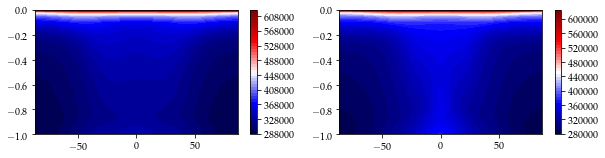

In [17]:
Cp=1000; L=2260*1000; g=10
field=Cp*T+g*Z+L*q
m=0
lat=div[0]['latn']
ind=np.squeeze(np.where((lat>0) & (lat<90)))
py.figure(figsize=(10,5))
for d in range(len(DEPTHS)):
    py.subplot(2,2,d+1)
    x=np.squeeze(field[d,:,:,:].mean(axis=-1).transpose())
    py.contourf(lat,(-sigma_full/1000), x, 50,cmap=cm.seismic); py.colorbar()

In [18]:
def N_S_avg(TE, SE, MM, NE, temp, lat, flux_flag=-1):
    l_N=((lat>-0.1) & (lat<=90))            
    l_S=((lat>=-90) & (lat<=0))
    
    avg = lambda x: (x[:,l_N,...]+flux_flag*np.roll(x[:,l_S,...][:,::-1,...], 6, axis=-1))/2.0
    
    TE1= avg(TE)
    SE1= avg(SE)
    NE1= avg(NE)
    MM1= avg(MM)
    temp= avg(temp)
    
    a= lambda x: np.append(x,x[...,0,None],axis=-1)
    
    return a(TE1), a(SE1), a(MM1), a(NE1), a(temp), lat[l_N]

In [19]:
TE_a   ,SE_a     , MM_a   , NE_a     ,ignore,  lat_a = N_S_avg(TE, SE, MM, NE,NE, lat)
TEv_a  ,SEv_a    , MMv_a  , NEv_a    ,ignore,  lat_a = N_S_avg(TEv, SEv, MMv, NEv,NEv, lat)
Iswabs_a,Ishf_a  , Ine_a , Iolr_a, Idhdt_a, latr_a = N_S_avg( Iswabs,Ishf,Ine,Iolr,Idhdt, lat[1:-1] )
ISW_sfc_a, ILW_sfc_a  , ISW_toa_a , Ishflx_a, Ilhflx_a, latr_a = N_S_avg( ISW_sfc,ILW_sfc,ISW_toa, Ishflx, Ilhflx, lat[1:-1] )
ISFC_a = N_S_avg( ISFC,ISFC,ISFC,ISFC,ISFC, lat[1:-1] )[0]
ITOA_a = N_S_avg( ITOA,ITOA,ITOA,ITOA,ITOA, lat[1:-1] )[0]

CpTv_a  ,gZv_a    , Lqv_a  , MSEv_a    ,ignore,  lat_a = N_S_avg(Cp*T, g*Z, L*q, Cp*T+g*Z+L*q,Cp*T, lat, 1)

In [20]:
dtheta=np.radians(lat_a[1]-lat_a[0])

def spher_div(x):
       N=100
       fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       for d in range(len(DEPTHS)):
        for m in range(13):
           div[d,:,m]= smooth( np.gradient((x[d,:,m])*(fac),dtheta)/( 2*np.pi*R**2*np.cos(np.radians(lat_a[:])) ),N)
       return div


div_TE_a=spher_div(TE_a*10**15)
div_SE_a=spher_div(SE_a*10**15)
div_MM_a=spher_div(MM_a*10**15)
div_NE_a=div_TE_a+div_SE_a+div_MM_a

# div_TEv_a, div_SEv_a, div_MMv_a, div_NEv_a,ignore,lat_a = N_S_avg(div_TEv, div_SEv, div_MMv, div_NEv,div_NEv, lat,flux_flag=1)

In [21]:
lat=div[0]['latn']

from scipy.interpolate import interp1d

def find_zero(div,zero=0):
  zero_loc = np.zeros((len(DEPTHS),13))
  for d in range(0,len(DEPTHS)):
      for m in range(0,13):
            l_range=((lat_a>=30) & (lat_a<=60))            
            interpolation_function = interp1d(div[d,l_range,m],lat_a[l_range],kind='linear')
            try :
                zero_loc[d,m]=interpolation_function(zero)
            except ValueError as err:
                zero_loc[d,m]=np.nan        
  return zero_loc

storm_pos=find_zero(div_TE_a)

In [22]:
dtheta=np.radians(lat_a[1]-lat_a[0])

def spher_div_vert(x):
       N=100
       fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       for d in range(len(DEPTHS)):
        for p in range(len(sigma_full)):
          for m in range(13):
            div[d,:,p,m]= smooth( np.gradient((x[d,:,p,m])*(fac)/R,dtheta),N)
       return div


div_CpT=spher_div_vert(CpTv_a)
div_gZ=spher_div_vert(gZv_a)
div_Lq=spher_div_vert(Lqv_a)
div_MSE=spher_div_vert(MSEv_a)

# div_TEv_a, div_SEv_a, div_MMv_a, div_NEv_a,ignore,lat_a = N_S_avg(div_TEv, div_SEv, div_MMv, div_NEv,div_NEv, lat,flux_flag=1)

In [23]:
div_CpT.shape

(2, 871, 24, 13)

In [24]:
# Cp=1000; L=2260*1000; g=10
# field=div_CpT
# m=m+1
# lat=div[0]['latn']
# ind=np.squeeze(np.where((lat>0) & (lat<90)))
# py.figure(figsize=(10,5))
# for d in range(len(DEPTHS)):
#     py.subplot(2,2,d+1)
#     x=np.squeeze(field[d,:,:,m].transpose())
#     py.contourf(lat_a,(-sigma_full/1000), x, 50,cmap=cm.seismic); py.colorbar()

In [25]:
# d=0
# py.figure(figsize=(15,6))
# field=MSEv_a
# v=np.linspace(np.min(field), 430000,30)
# for m in range(12):
#     py.subplot(3,4,m+1)
#     py.contourf(lat_a,sigma_full, (field[d,...,m]).transpose(),v,cmap=cm.seismic);py.colorbar()
#     c=py.contour(lat_a,sigma_full, (TEv_a[d,...,m]).transpose(),colors='k')#; py.colorbar()
#     py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=10)
#     py.gca().invert_yaxis()
# #     py.xlim(20,70)
# py.tight_layout()

In [26]:
import numpy.ma as ma

threshold=0.001
mask_of_TE      = ma.masked_greater_equal(TEv_a, threshold)  ### Positive transient eddies
mask_of_div_MSE = ma.masked_less_equal(div_MSE, -1*threshold) ### Negative MSE gradient

not_mask_of_TE      = ma.masked_less(TEv_a, threshold)  ### Positive transient eddies
not_mask_of_div_MSE = ma.masked_greater(div_MSE, -1*threshold) ### Negative MSE gradient
masked_div_MSE = ma.masked_where( ma.getmask(not_mask_of_div_MSE) , div_MSE)
masked_TE      = ma.masked_where( ma.getmask(not_mask_of_TE), TEv_a)


### Masked div MSE  - all pressure levels

In [27]:
# d=0
# py.figure(figsize=(15,6))
# field=masked_div_MSE
# v=np.linspace(np.nanmin(field),0,10)
# for m in range(12):
#     py.subplot(3,4,m+1)
#     py.contourf(lat_a,sigma_full, (field[d,...,m]).transpose(),v, cmap=rcmap(cm.Blues));py.colorbar()
#     c=py.contour(lat_a,sigma_full, (masked_TE[d,...,m]).transpose(),colors='k')#; py.colorbar()
#     py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=10)
#     py.gca().invert_yaxis()
# #     py.xlim(20,70)
# py.suptitle("div MSE",fontsize=20,y=1.05)
# py.tight_layout()
# py.show()

### Masked TE  - all pressure levels

In [28]:
# d=0
# py.figure(figsize=(15,6))
# field=masked_TE
# v=np.linspace(0,np.nanmax(field),30)
# for m in range(12):
#     py.subplot(3,4,m+1)
#     py.contourf(lat_a,sigma_full, (field[d,...,m]).transpose(),v, cmap=(cm.Reds));py.colorbar()
#     c=py.contour(lat_a,sigma_full, (masked_TE[d,...,m]).transpose(),colors='k')#; py.colorbar()
#     py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=10)
#     py.gca().invert_yaxis()
# #     py.xlim(20,70)
# py.suptitle("TE",fontsize=20,y=1.05)
# py.tight_layout()
# py.show()

### Masked diffusivity - all pressure levels

In [29]:
# diffusivity= -1*(masked_TE/masked_div_MSE)

# d=0
# py.figure(figsize=(15,6))
# field=diffusivity
# v=np.linspace(0,90,10)
# for m in range(12):
#     py.subplot(3,4,m+1)
#     py.contourf(lat_a,sigma_full, (field[d,...,m]).transpose(),v, cmap=(cm.Purples));py.colorbar()
#     c=py.contour(lat_a,sigma_full, (masked_TE[d,...,m]).transpose(),colors='k')#; py.colorbar()
#     py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=10)
#     py.gca().invert_yaxis()
# #     py.xlim(20,70)
# py.suptitle("Diffusivity",fontsize=20,y=1.05)
# py.tight_layout()
# py.show()

### My definition of diffusivity - all pressure levels

In [30]:
# def mean(X):
# #     return X[...,:-1].mean(axis=-1)[...,None]
#       return (np.asarray( [X[...,:-1].mean(axis=-1)]*13).transpose(1,2,3,0))
# def prime(X):
#     return X-mean(X)

# D_mean =mean(diffusivity)
# Im_mean=mean(masked_div_MSE)
# I_mean =mean(masked_TE)

# D_prime =prime(diffusivity)
# Im_prime=prime(masked_div_MSE)
# I_prime =prime(masked_TE)

## $I^{\prime}=\overline{D^{\prime}I_{m}^{\prime}}-D^{\prime}I_{m}^{\prime}-D^{\prime}\overline{I_{m}}-\overline{D}I_{m}^{\prime}$

In [31]:
# i1= mean(D_prime*Im_prime)
# i2= -1*D_prime*Im_prime
# i3= -1*D_prime*Im_mean
# i4= -1*D_mean*Im_prime

In [32]:
def plot_vert_months(field,d,title):
    py.figure(figsize=(15,6))
    v=np.arange(-0.50,0.501,0.001)
    for m in range(12):
        py.subplot(3,4,m+1)
        py.contourf(lat_a,sigma_full, (field[d,...,m]).transpose(),v, cmap=(cm.seismic));py.colorbar()
        c=py.contour(lat_a,sigma_full, (prime(masked_TE)[d,...,m]).transpose(),colors='k')#; py.colorbar()
        py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=12, fontsize=10)
        py.gca().invert_yaxis()
    #     py.xlim(20,70)
    py.suptitle(title,fontsize=20,y=1.05)
    py.tight_layout()
    py.show()

In [33]:
# plot_vert_months(i1,0,r'$\overline{D^{\prime}I_{m}^{\prime}}$')

In [34]:
# plot_vert_months(i2,0,r'$-D^{\prime}I_{m}^{\prime}$')

In [35]:
# plot_vert_months(i3,0,r'$-D^{\prime}\overline{I_{m}}$')

In [36]:
# plot_vert_months(i4,0,r'$-\overline{D}I_{m}^{\prime}$')

In [37]:
# plot_vert_months(i1+i2+i3+i4,0,r'$I^{\prime}$')

In [38]:
# i1_sum=np.nansum(i1,axis=2);
# i2_sum=np.nansum(i2,axis=2);
# i3_sum=np.nansum(i3,axis=2);
# i4_sum=np.nansum(i4,axis=2);

# I1=r'$\overline{D^{\prime}I_{m}^{\prime}}$'
# I2=r'$-D^{\prime}I_{m}^{\prime}$'
# I3=r'$-D^{\prime}\overline{I_{m}}$'
# I4=r'$-\overline{D}I_{m}^{\prime}$'
# ISUM=r'$I^{\prime}=\overline{D^{\prime}I_{m}^{\prime}}-D^{\prime}I_{m}^{\prime}-D^{\prime}\overline{I_{m}}-\overline{D}I_{m}^{\prime}$'
# Iorig=r'$\Delta\langle[\overline{v^{\prime}m^{\prime}}]\rangle$'

# I1=r'$ ({\Delta D \Delta I_{m}})_{o}$'
# I2=r'$-(\Delta D) (\Delta I_{m})$'
# I3=r'$-(\Delta D) {I_{m_{o}}}$'
# I4=r'$-{D_{o}} (\Delta I_{m})$'
# ISUM=r'$\Delta I =$ '+I1 +I2 +I3 +I4
# Iorig=r'$\Delta I =$' + r'$\Delta\langle[\overline{v^{\prime}m^{\prime}}]\rangle$'

# i_sum = np.nansum(i1+i2+i3+i4,axis=2)
# TE_prime=prime(TEv_a).sum(axis=2)  ## Note TE_prime is same as i_sum

In [39]:
# pick the storm track position and identify the index
from scipy.interpolate import interp1d
def inerp_at_max(flux,lat):
  D = np.zeros((len(DEPTHS),13))
  for d in range(0,len(DEPTHS)):
    for m in range(0,13):
        l_range=((lat>=30) & (lat<=60)) 
        X=storm_pos
        interpolation_function = interp1d(lat[l_range],flux[d,l_range,m],kind='cubic')
        try :
            D[d,m]=interpolation_function(X[d,m])
        except ValueError as err:
            D[d,m]==np.nan        
  return D

Intensity_te=inerp_at_max(TE_a,lat_a)
Intensity_se=inerp_at_max(SE_a,lat_a)
Intensity_mm=inerp_at_max(MM_a,lat_a)
Intensity_ne=inerp_at_max(NE_a,lat_a)

### Interp i1 i2 at storm track position

In [40]:
# i1_a=inerp_at_max(i1_sum,lat_a)
# i2_a=inerp_at_max(i2_sum,lat_a)
# i3_a=inerp_at_max(i3_sum,lat_a)
# i4_a=inerp_at_max(i4_sum,lat_a)

# i_a       =inerp_at_max(i_sum,lat_a)
# teprime_a =inerp_at_max(TE_prime,lat_a)

In [41]:
def plot_at_storm_position(d,l,month_to_month=1):
    
    DEPTHS_title=["5m","50m"]     
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    def D(y,d):
        if month_to_month==1 :
            y1=y#np.append(y,y[:,0,np.newaxis],axis=1)
            x1=y1[d,1:]-y1[d,:-1]
            x2=np.append(x1[-1],x1)
            mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
        else :
            y1=y[d,:]-np.nanmean(y[d,:-1,None],axis=0)
            x2=y1
            mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        return x2
#     def D(y,d):
#         return y[d,...]
    
    if month_to_month==1 :
        mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    else :
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    
    py.plot(D(i3_a,d),'ko-',label=I3,lw=3.5)
    py.plot(D(i4_a,d),'bo-',label=I4,lw=3.5)
        
#     py.plot(D(i1_a,d),'co-',label=r'$+$'+I1,lw=3.5)
#     py.plot(D(i2_a,d),'yo-',label=I2,lw=3.5)   
    
#     py.plot(D(i_a,d),'ro-',label=r'$\Delta I_{calc}$',lw=3.5) 
    #py.plot(D(teprime_a,d),'ro-',label=r'$\Delta I$',lw=3.5) 
    py.plot(D(Intensity_te,d),'ro-',label=r'$\Delta I$',lw=3.5) 

                                              
    py.axhline(0, color='k',linewidth=1.5)
    py.xlim(0,12)
    py.ylim(-1*l,l)
    py.ylabel("PW", fontsize=40)
    title=""+" "+" "+str(depth)+"m"
    py.title(str(DEPTHS_title[d]),fontsize=35,y=1.03)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.legend(loc='best',fontsize=20,ncol=2,frameon=False)
    py.tight_layout()

## Plot my definition of Diffusivity decomposition

In [42]:
# l=6.0; i=0;
# fig=py.figure(figsize=(38, 12))
# for d in range(len(DEPTHS)):
#     py.subplot(2,4,i+1)
#     plot_at_storm_position(d,l,0)
#     i=i+1
#     py.tight_layout()

## Plot my definition of Diffusivity decomposition

In [43]:
# d=0
# py.figure(figsize=(15,10))
# r=3; c=2; n=0
# v=np.arange(-7.5,7.75, 0.25); n=n+1
# py.subplot(r,c,n); py.title(Iorig,fontsize=20)
# py.contourf(range(13),lat_a,TE_prime[d,...],v, cmap=cm.seismic);py.colorbar();n=n+1
# py.plot(range(13),storm_pos[d,:])

# py.subplot(r,c,n); py.title(ISUM,fontsize=20)
# py.contourf(range(13),lat_a,i_sum[d,...],v, cmap=cm.seismic);py.colorbar(); n=n+1
# py.plot(range(13),storm_pos[d,:])

# py.subplot(r,c,n);      py.title(I1,fontsize=20)
# py.contourf(range(13),lat_a,i1_sum[d,...],v, cmap=cm.seismic);py.colorbar();n=n+1
# py.plot(range(13),storm_pos[d,:])

# py.subplot(r,c,n);      py.title(I2,fontsize=20)
# py.contourf(range(13),lat_a,i2_sum[d,...],v, cmap=cm.seismic);py.colorbar();n=n+1
# py.plot(range(13),storm_pos[d,:])

# py.subplot(r,c,n);      py.title(I3,fontsize=20)
# py.contourf(range(13),lat_a,i3_sum[d,...],v, cmap=cm.seismic);py.colorbar();n=n+1
# py.plot(range(13),storm_pos[d,:])

# py.subplot(r,c,n);      py.title(I4,fontsize=20)
# py.contourf(range(13),lat_a,i4_sum[d,...],v, cmap=cm.seismic);py.colorbar();n=n+1
# py.plot(range(13),storm_pos[d,:])
# py.tight_layout()

In [44]:
# d=1
# py.figure(figsize=(15,10))
# r=3; c=2; n=0
# v=np.arange(-4.0,4.25, 0.25); n=n+1
# py.subplot(r,c,n); py.title(Iorig,fontsize=20)
# py.contourf(range(13),lat_a,TE_prime[d,...],v, cmap=cm.seismic);py.colorbar();n=n+1
# py.plot(range(13),storm_pos[d,:])

# py.subplot(r,c,n); py.title(ISUM,fontsize=20)
# py.contourf(range(13),lat_a,i_sum[d,...],v, cmap=cm.seismic);py.colorbar(); n=n+1
# py.plot(range(13),storm_pos[d,:])

# py.subplot(r,c,n);      py.title(I1,fontsize=20)
# py.contourf(range(13),lat_a,i1_sum[d,...],v, cmap=cm.seismic);py.colorbar();n=n+1
# py.plot(range(13),storm_pos[d,:])

# py.subplot(r,c,n);      py.title(I2,fontsize=20)
# py.contourf(range(13),lat_a,i2_sum[d,...],v, cmap=cm.seismic);py.colorbar();n=n+1
# py.plot(range(13),storm_pos[d,:])

# py.subplot(r,c,n);      py.title(I3,fontsize=20)
# py.contourf(range(13),lat_a,i3_sum[d,...],v, cmap=cm.seismic);py.colorbar();n=n+1
# py.plot(range(13),storm_pos[d,:])

# py.subplot(r,c,n);      py.title(I4,fontsize=20)
# py.contourf(range(13),lat_a,i4_sum[d,...],v, cmap=cm.seismic);py.colorbar();n=n+1
# py.plot(range(13),storm_pos[d,:])

# py.tight_layout()

## Diffusivity at the surface 

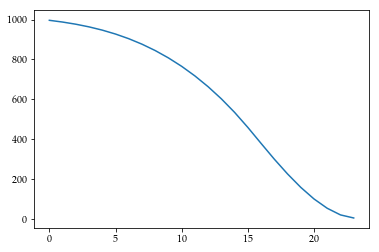

In [45]:
py.plot(sigma_full)

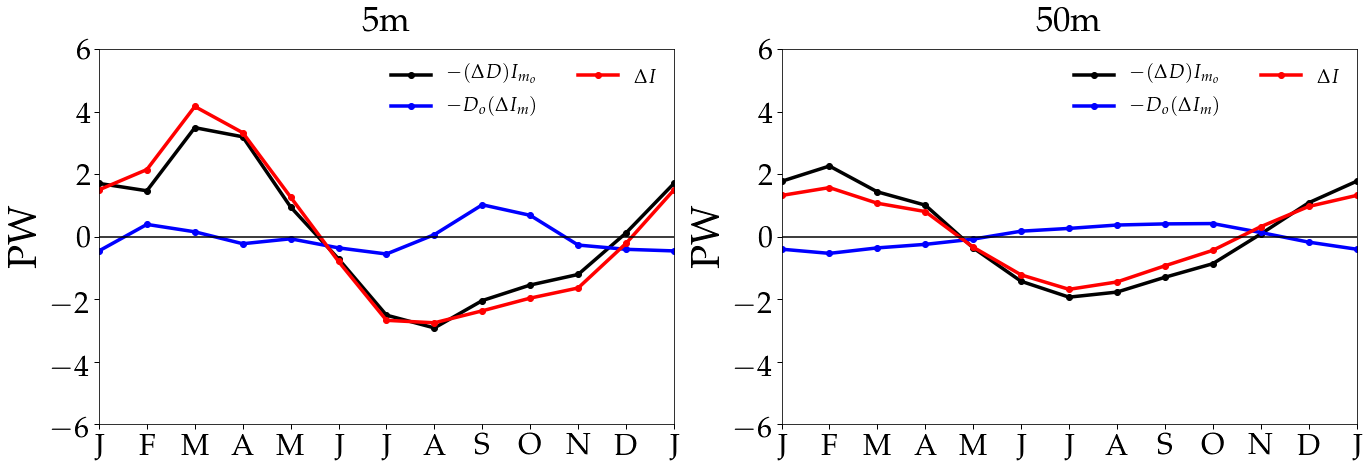

In [46]:
level=5

import numpy.ma as ma

dm_by_dphi       = masked_div_MSE[...,level,:]
not_mask_of_TE_a = ma.masked_less(TE_a, threshold)  ### Positive transient eddies
masked_TE_a      = ma.masked_where( ma.getmask(not_mask_of_TE_a), TE_a)
diffusivity_sfc  = -TE_a/dm_by_dphi

def mean(X):
     return np.nanmean(X[...,:-1],axis=-1)[...,None]
def prime(X):
    return X-mean(X)


D_mean =mean(diffusivity_sfc)
Im_mean=mean(dm_by_dphi)
I_mean =mean(TE_a)

D_prime =prime(diffusivity_sfc)
Im_prime=prime(dm_by_dphi)
I_prime =prime(TE_a)

i1= mean(D_prime*Im_prime)
i1= (np.asarray( [np.squeeze(i1)]*13).transpose(1,2,0))
i2= -1*D_prime*Im_prime
i3= -1*D_prime*Im_mean
i4= -1*D_mean*Im_prime

i1_a=inerp_at_max(i1,lat_a)
i2_a=inerp_at_max(i2,lat_a)
i3_a=inerp_at_max(i3,lat_a)
i4_a=inerp_at_max(i4,lat_a)

#i_a       =inerp_at_max(i_sum,lat_a)
# teprime_a=inerp_at_max(TE_prime,lat_a)

l=6.0; i=0;
fig=py.figure(figsize=(38, 12))
for d in range(len(DEPTHS)):
    py.subplot(2,4,i+1)
    plot_at_storm_position(d,l,0)
    i=i+1
    py.tight_layout()


## For shift decomposition

In [47]:
level=level

threshold=0.001
high =10**10

mask_of_TE_a            = ma.masked_less(TE_a, threshold)  ### Positive transient eddies
mask_of_div_MSE_a       = ma.masked_greater(div_MSE[...,level,:], -1*threshold) ### Negative MSE gradient
masked_div_MSE_a        = ma.masked_where( ma.getmask(mask_of_div_MSE_a) , div_MSE[...,level,:])
masked_TE_a             = ma.masked_where( ma.getmask(mask_of_TE_a), TE_a)

def mask_of_extreme_high_low(y,high):
    sh   = ma.masked_greater(y, high)
    sl   = ma.masked_less(y, -1*high)  
    maskh= ma.getmask(sh)
    maskl= ma.getmask(sl)
    masked_s = ma.masked_where( maskh, y)
    masked_s = ma.masked_where( maskl, masked_s)
    return masked_s


def smooth_multi(y, box_pts,smoothing=1):
    box = np.ones(box_pts)/box_pts
    y_smooth=np.apply_along_axis(np.convolve, 1, y, box, mode='same')
    if smoothing == 1 :
        return y_smooth
    else :
        return y
    

dm_by_dphi      =  masked_div_MSE_a
diffusivity_sfc = -masked_TE_a/dm_by_dphi


dm2_by_dphi2              = spher_div(div_MSE[...,level,:])*10**15
dm2_by_dphi2              = ma.masked_where( ma.getmask(mask_of_div_MSE_a), dm2_by_dphi2)
dm2_by_dphi2              = ma.masked_where( ma.getmask(mask_of_TE_a), dm2_by_dphi2)

div_diffusivity_sfc       = spher_div(diffusivity_sfc)*10**15
div_diffusivity_sfc       = ma.masked_where( ma.getmask(mask_of_TE_a), div_diffusivity_sfc)
div_diffusivity_sfc       = ma.masked_where( ma.getmask(mask_of_div_MSE_a), div_diffusivity_sfc)
div_diffusivity_sfc       = mask_of_extreme_high_low(div_diffusivity_sfc,high=10**9)

Im_dD_by_dphi             = -1*dm_by_dphi*div_diffusivity_sfc
D_dIm_by_dphi             = -1*diffusivity_sfc*dm2_by_dphi2

N=50
d1  =   smooth_multi(-1*mean(div_diffusivity_sfc)*prime(dm_by_dphi),N,-1) 
d2  =   smooth_multi(-1*prime(div_diffusivity_sfc)*mean(dm_by_dphi),N,1)
d3  =   smooth_multi(-1*prime(div_diffusivity_sfc)*prime(dm_by_dphi),N,1) 

d4  =   smooth_multi(-1*mean(diffusivity_sfc)*prime(dm2_by_dphi2),N,1)
d5  =   smooth_multi(-1*prime(diffusivity_sfc)*mean(dm2_by_dphi2),N,1)
d6  =   smooth_multi(-1*prime(diffusivity_sfc)*prime(dm2_by_dphi2),N,1)

d3m =   smooth_multi(-1*np.asarray( [np.squeeze(mean(d3))]*13).transpose(1,2,0),N)
d4m =   smooth_multi(-1*np.asarray( [np.squeeze(mean(d4))]*13).transpose(1,2,0),N)

F   =    mean(div_TE_a)

In [48]:
import numpy as np
def calculate_shift_just_by_adding_individual_flux_divergences(month_to_month=1):
    
    div_TE_a=spher_div(TE_a*10**15)
    
    te=div_TE_a
    
    def diff(x):
        return x[:,:,1:]-x[:,:,:-1] 
    base_pos=te[...,:-1]
    
    if month_to_month==0 :
      def diff(x):
         return x[:,:,1:]-x[...,1:,None].mean(axis=2)    
      base_pos=te[...,1:,None].mean(axis=2)
    
    TE_change=base_pos+diff(div_TE_a)
    d1_change=base_pos+diff(d1)
    d2_change=base_pos+diff(d2)
    d3_change=base_pos+diff(d3)
    d4_change=base_pos+diff(d4)
    d5_change=base_pos+diff(d5)
    d6_change=base_pos+diff(d6)
    
    a = lambda x: np.append(x[:,:,-1,None],x,axis=-1)
    
    return a(TE_change), a(d1_change), a(d2_change), a(d3_change), a(d4_change), a(d5_change), a(d6_change)

d_changes = calculate_shift_just_by_adding_individual_flux_divergences(month_to_month=0)

In [49]:
# i=4 and m=4 ll=30 ul=42
# i=0 and m=4 ll=45 ul=60

def find_zero(div,i,zero=0):
  depths=div.shape[0];
  months=div.shape[-1];
  zero_loc = np.zeros((depths,months))
  for d in range(0,depths):
      for m in range(0,months):
            if ((d==0) & ((m==6) | (m==7) | (m==8) | (m==9) | (m==10)) & (i==2)) :
               l_range=((lat_a>=45) & (lat_a<=60))
            elif ((d==0) & ((m==4)) & (i==4)) :
               l_range=((lat_a>=30) & (lat_a<=42))
            elif ((d==0) & ((m==6)) & (i==0)) :
               l_range=((lat_a>=37) & (lat_a<=60))
            else:
               l_range=((lat_a>=33) & (lat_a<=60))
            interpolation_function = interp1d(div[d,l_range,m],lat_a[l_range],kind='linear')
            try :
                zero_loc[d,m]=interpolation_function(zero)
            except ValueError as err:
                zero_loc[d,m]=np.nan        
  return zero_loc

In [50]:
i=0
# for i in range(7): find_zero(d_changes[i])

In [51]:
def threshold(I,value, position):
      for d in range(len(DEPTHS)):  
        for m in range(13):
            if (np.abs(I[d,m])<value) :
                for l in range(np.shape(position)[0]):
                   position[l][d,m]=np.nan
      return position

positions = threshold(Intensity_te, 0.0, [find_zero(d_changes[i],i) for i in range(7)])
positions[0]= find_zero(d_changes[0],0,zero=-6.0)

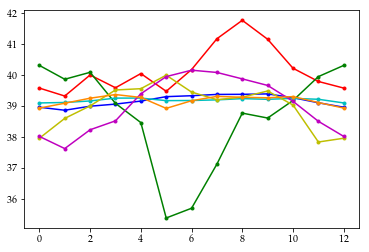

In [52]:
d=1
py.plot(positions[0][d,:],'r.-')
py.plot(positions[1][d,:],'b.-')
py.plot(positions[2][d,:],'g.-')
py.plot(positions[3][d,:],'c.-')
py.plot(positions[4][d,:],'y.-')
py.plot(positions[5][d,:],'m.-')
py.plot(positions[6][d,:],'.-',c='#ff8a00ff')

In [55]:
py.rc('text', usetex=True)
py.rc('font', family='serif', serif='Palatino',weight='bold')

def plot_monthly_shift(d,l,month_to_month=0,threshold_value=0.0) :
        
    DEPTHS_title=["5m", "50m"]
    I=Intensity_te    
    n=d+1    
    d_changes = calculate_shift_just_by_adding_individual_flux_divergences(month_to_month)
    positions = threshold(Intensity_te, threshold_value, [find_zero(d_changes[i],i) for i in range(7)])  
    positions[0]= find_zero(d_changes[0],0,zero=-5.0)
    m=range(0,13)

    mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    
    zero_div_TE=positions[0]
    TE_change=d_changes[0]
    base_pos=zero_div_TE[d,:-1]
    def add_month_to_end(y1) :
        y=np.append(y1[-1],y1)
        return y
        
    if month_to_month==0:
        s=TE_change[d,:,1:].mean(axis=-1)[None,:,None]
        base_pos=np.squeeze(find_zero(s,0))
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        #base_pos=44 #np.nanmean(zero_div_TE[d,:-1])
        print base_pos
        
    TE_obs_pos         = add_month_to_end(zero_div_TE[d,1:]-base_pos)
    d1_pos             = add_month_to_end(positions[1][d,1:]-base_pos)
    d2_pos             = add_month_to_end(positions[2][d,1:]-base_pos)
    d3_pos             = add_month_to_end(positions[3][d,1:]-base_pos)
    d4_pos             = add_month_to_end(positions[4][d,1:]-base_pos)
    d5_pos             = add_month_to_end(positions[5][d,1:]-base_pos)
    d6_pos             = add_month_to_end(positions[6][d,1:]-base_pos)
    TE_calc_pos        = d1_pos+d2_pos+d3_pos+d4_pos+d5_pos+d6_pos
    nonlinear_error    = TE_obs_pos-TE_calc_pos        
#     py.subplot(220+n)
#     py.subplot(2,4,n)
    fig=py.plot(TE_obs_pos,'r.-',label=r'$\Delta\phi$',linewidth=3.5,markersize=10)
    fig=py.plot(d1_pos+d4_pos,'b.-',label=r'$\Delta\phi_{{{1}}}$',linewidth=2.0,markersize=10)
    fig=py.plot(d2_pos+d5_pos,'k.-',label=r'$\Delta\phi_{{{2}}}$',linewidth=3.5,markersize=10)
#     fig=py.plot(d3_pos,'c.-',label=r'$\Delta\phi_{{{3}}}$',linewidth=2.0,markersize=10)
#     fig=py.plot(d4_pos,'y.-',label=r'$\Delta\phi_{{{4}}}$',linewidth=2.0,markersize=10)
#     fig=py.plot(d5_pos,'m.-',label=r'$\Delta\phi_{{{5}}}$',linewidth=2.0,markersize=10)
#     fig=py.plot(d6_pos,'.-',c='#ff8a00ff',label=r'$\Delta\phi_{{{6}}}$',linewidth=2.0,markersize=10)
#     fig=py.plot(nonlinear_error,'k.-',label=r'${nonlinear}$',linewidth=2.0,markersize=10)
#     print TE_obs_pos.shape
    py.axhline(0, color='k',linewidth=1.5)
    py.xlim(0,12)
    py.ylim(-1*l,+1*l)
    py.ylabel("deg \\ poleward", fontsize=25)

    title="shift decomposition"+" "+" ("+str(depth)+"m)"
    title1="shift_decomp"+"_"+str(depth)+"m"
    py.title(str(DEPTHS_title[d]),fontsize=30,y=1.03)
    #py.title(title, fontsize=35)
    py.xticks(m, mticks,size=15)
    py.tick_params(labelsize=20,size=4,width=2)
    py.axhspan(-1.0, 1.0, facecolor='0.5', alpha=0.3)
    py.tight_layout()
    if d==1:
        py.legend(loc='best',fontsize=20,ncol=3,frameon=False)
    py.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.10, wspace=0.15, hspace=0.3)
   
    

$\begin{alignat}{1}
\Delta F= & \underset{d_{1}}{\underbrace{-\partial_{y}D_{o}\Delta(I_{m})}}\ \ \ \underset{d_{2}}{\underbrace{-\Delta\left(\partial_{y}D\right)I_{m_{o}}}}\ \ \ \underset{d_{3}}{\underbrace{-\Delta\left(\partial_{y}D\right)\Delta(I_{m})}}\nonumber \\
 & \underset{d_{4}}{\underbrace{-D_{o}\Delta(\partial_{y}I_{m})}}\underset{d_{5}}{\ \underbrace{\ \ -\Delta\left(D\right)\partial_{y}I_{m_{o}}}\ \ \ }\underset{d_{6}}{\underbrace{-\Delta\left(D\right)\Delta(\partial_{y}I_{m})}}
\end{alignat}$

$\begin{equation}
\Delta\phi=\Delta\phi_{1}+\Delta\phi_{2}+\Delta\phi_{3}+\Delta\phi_{4}+\Delta\phi_{5}+\Delta\phi_{6}+\Delta\phi_{CT}
\end{equation}$

39.20080333581809
44.03805013081176


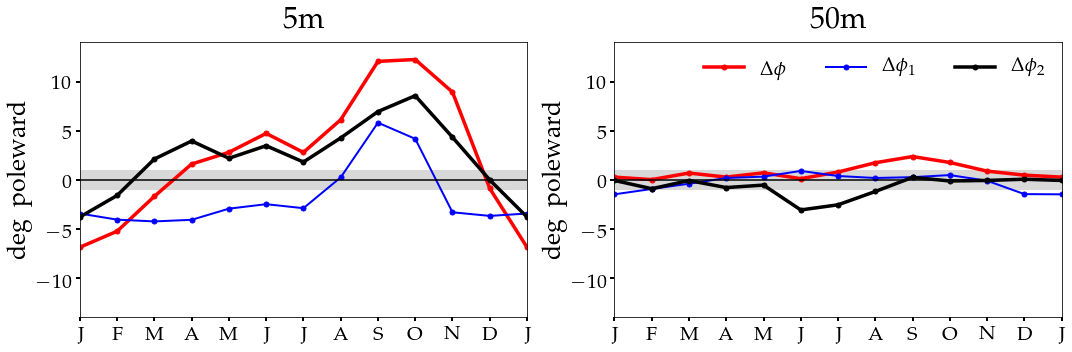

In [57]:
py.figure(figsize=(15,5))
l=14
for d in [1,0]:
    py.subplot(1,2,d+1)
    plot_monthly_shift(d,l,month_to_month=0,threshold_value=0.0)
py.tight_layout()
py.savefig("GFDL_diffusivity.pdf")

In [ ]:
region=np.squeeze(np.where( (lat_a>30) & (lat_a<60) ))
py.figure(figsize=(20,10))
v=np.linspace(-150,150,20)
def cont_plot(field,n):
    py.subplot(4,3,n)
    py.contourf(range(13),lat_a[region], field[0,region,...],v, cmap=cm.seismic); py.colorbar()
    if n<=6:
      py.plot(positions[n][0,:],'o-')
    
cont_plot(d1,1)
cont_plot(d2,2)
cont_plot(d3,3)

cont_plot(d4,4)
cont_plot(d5,5)
cont_plot(d6,6)

cont_plot(d1+d2+d3+d4+d5+d6,7)
py.plot(positions[0][d,:],'o-')
cont_plot(prime(div_TE_a),8)
py.plot(positions[0][d,:],'o-')
py.tight_layout()

In [ ]:
d=0
region=np.squeeze(np.where(lat_a>30))
py.figure(figsize=(20,10))
v=np.linspace(-250,250,90)
def cont_plot_main(field,n):
    py.subplot(4,3,n)
    py.contourf(range(13),lat_a[region], (F+prime(field))[d,region,...],v, cmap=cm.seismic); py.colorbar()
    if n<=6:
      py.plot(positions[n][d,:],'o-')
    py.ylim(30,60)
    
cont_plot_main(d1,1)
cont_plot_main(d2,2)
cont_plot_main(d3,3)

cont_plot_main(d4,4)
cont_plot_main(d5,5)
cont_plot_main(d6,6)

cont_plot_main(d1+d2+d3+d4+d5+d6,7)
py.plot(positions[0][d,:],'o-')
cont_plot_main(prime(div_TE_a),8)
py.plot(positions[0][d,:],'o-')
py.tight_layout()


In [ ]:
d=1
region=np.squeeze(np.where(lat_a>30))
py.figure(figsize=(20,10))
v=np.linspace(-250,250,90)
def cont_plot_main(field,n):
    py.subplot(4,3,n)
    py.contourf(range(13),lat_a[region], (F+prime(field))[d,region,...],v, cmap=cm.seismic); py.colorbar()
    if n<=6:
      py.plot(positions[n][d,:],'o-')
    py.ylim(30,60)
    
cont_plot_main(d1,1)
cont_plot_main(d2,2)
cont_plot_main(d3,3)

cont_plot_main(d4,4)
cont_plot_main(d5,5)
cont_plot_main(d6,6)

cont_plot_main(d1+d2+d3+d4+d5+d6,7)
py.plot(positions[0][d,:],'o-')
cont_plot_main(prime(div_TE_a),8)
py.plot(positions[0][d,:],'o-')
py.tight_layout()


In [ ]:
d=0
region=np.squeeze(np.where(lat_a>38))
py.figure(figsize=(20,10))
v=np.linspace(-250,250,90)
def cont_plot_main(field,n):
    py.subplot(4,3,n)
    py.contourf(range(13),lat_a[region], (F+prime(field))[d,region,...],v, cmap=cm.seismic); py.colorbar()
    if n<=6:
      py.plot(positions[n][d,:],'o-')
    py.ylim(38,60)
    
cont_plot_main(d1,1)
cont_plot_main(d2,2)
cont_plot_main(d3,3)

cont_plot_main(d4,4)
cont_plot_main(d5,5)
cont_plot_main(d6,6)

cont_plot_main(d1+d2+d3+d4+d5+d6,7)
py.plot(positions[0][d,:],'o-')
cont_plot_main(prime(div_TE_a),8)
py.plot(positions[0][d,:],'o-')
py.tight_layout()
